# Assignment 1: Data quality issues

## Project flow
- Data quality identification
- Data quality issue handeling
    - missing values
    - outliers
    - cardinality
- Train base model (Decision Tree)
- Do hyper parameter tuning to get the best order of parameters
- Train base model (k-nn)
- Do hyper parameter tuning to get the best order of parameters
- Get the generalization of the best model
- Evaluate the difference in performance of the 2 classifiers 
    - Use the McNemar calculation
    - Use the 5 x 2 cross-validation paired t-test
- Choose the best model



In [6]:
!pip install --upgrade scikit-learn

In [18]:
!pip install imbalanced-learn



  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.12.3-py3-none-any.whl (258 kB)


In [30]:
!pip install imbalanced-learn==0.12.3


  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.12.3-py3-none-any.whl (258 kB)
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.2
    Uninstalling imbalanced-learn-0.12.2:
      Successfully uninstalled imbalanced-learn-0.12.2


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

from imblearn.combine import SMOTETomek

In [2]:
!pip install  ptitprince

In [2]:
import ptitprince as pt

In [3]:
df = pd.read_excel('DryBeanDataSet.xlsx')
print(df.shape)
df.head()

(13611, 22)


Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0   84648   1132.054       439.915710       248.961941      1.767000   
1   39704    736.873       271.659919       186.481404      1.456767   
2   35835    687.914       237.704180       192.176759      1.236904   
3  223035   1817.278       680.812555       419.994347      1.621004   
4   41957    767.143       287.962974       186.166695      1.546802   

   Eccentricity  ConvexArea  Constantness  EquivDiameter Colour  ...  \
0      0.824453       86779             1     328.294351  brown  ...   
1      0.727175       40106             1     224.839282  black  ...   
2      0.588537       36190             1     213.603696  green  ...   
3      0.787040      225889             1     532.894907  brown  ...   
4      0.762918       42310             1     231.130508  brown  ...   

  roundness  Compactness  ShapeFactor1 ShapeFactor2  ShapeFactor3  \
0  0.830027     0.746266      0.005197     0.000994      0.556914   
1  0.918880      0.82765      0.006842     0.001980      0.685004   
2  0.951588     0.898611      0.006633     0.002668      0.807503   
3  0.848673     0.782734      0.003052     0.000707      0.612672   
4  0.895904      0.80264      0.006863     0.001757      0.644230   

   ShapeFactor4  ShapeFactor5  ShapeFactor6     Class Sort order  
0      3.487008      0.984066     50.809833      CALI   0.134791  
1      1.242335      0.997891    148.508874  DERMASON   0.898848  
2      2.813489      0.998803     82.107117     SEKER   0.539684  
3      3.074472      0.993144    147.347735    BOMBAY   0.149130  
4      2.213954      0.996497     22.893826      SIRA   0.447635  

[5 rows x 22 columns]

## Inspecting value types

In [4]:
df.dtypes

Area                 int64
Perimeter          float64
MajorAxisLength    float64
MinorAxisLength    float64
AspectRation       float64
Eccentricity       float64
ConvexArea           int64
Constantness         int64
EquivDiameter      float64
Colour              object
Extent              object
Solidity           float64
roundness          float64
Compactness         object
ShapeFactor1       float64
ShapeFactor2       float64
ShapeFactor3       float64
ShapeFactor4       float64
ShapeFactor5       float64
ShapeFactor6        object
Class               object
Sort order         float64
dtype: object

## Inspecting duplicate values

In [5]:
duplicates = df.duplicated()
# Filter and display duplicate rows
duplicate_rows = df[duplicates]

print(duplicate_rows)

Empty DataFrame
Columns: [Area, Perimeter, MajorAxisLength, MinorAxisLength, AspectRation, Eccentricity, ConvexArea, Constantness, EquivDiameter, Colour, Extent, Solidity, roundness, Compactness, ShapeFactor1, ShapeFactor2, ShapeFactor3, ShapeFactor4, ShapeFactor5, ShapeFactor6, Class, Sort order]
Index: []

[0 rows x 22 columns]


## Surface level null inspection

In [5]:
df.isnull().sum()

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
Constantness       0
EquivDiameter      0
Colour             0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
ShapeFactor5       0
ShapeFactor6       0
Class              0
Sort order         0
dtype: int64

## Describe the data in the dataset

In [6]:
df.describe()

Area     Perimeter  MajorAxisLength  MinorAxisLength  \
count   13611.000000  13611.000000     13611.000000     13611.000000   
mean    53048.284549    855.283459       320.141867       202.270714   
std     29324.095717    214.289696        85.694186        44.970091   
min     20420.000000    524.736000       183.601165       122.512653   
25%     36328.000000    703.523500       253.303633       175.848170   
50%     44652.000000    794.941000       296.883367       192.431733   
75%     61332.000000    977.213000       376.495012       217.031741   
max    254616.000000   1985.370000       738.860153       460.198497   

       AspectRation  Eccentricity     ConvexArea  Constantness  EquivDiameter  \
count  13611.000000  13611.000000   13611.000000  13611.000000   1.361100e+04   
mean       1.583242      0.750895   53765.692602      0.902873   4.762541e+02   
std        0.246678      0.092002   29778.009358      0.296142   2.583687e+04   
min        1.024868      0.218951     -30.000000      0.000000   1.614174e-01   
25%        1.432307      0.715928   36714.500000      1.000000   2.150680e+02   
50%        1.551124      0.764441   45178.000000      1.000000   2.384380e+02   
75%        1.707109      0.810466   62294.000000      1.000000   2.794522e+02   
max        2.430306      0.911423  263261.000000      1.000000   3.014441e+06   

           Solidity     roundness  ShapeFactor1  ShapeFactor2  ShapeFactor3  \
count  13611.000000  13611.000000  13611.000000  13611.000000  13611.000000   
mean       0.987143      0.873282      0.006564      0.001716      0.643590   
std        0.004660      0.059520      0.001128      0.000596      0.098996   
min        0.919246      0.489618      0.002778      0.000564      0.410339   
25%        0.985670      0.832096      0.005900      0.001154      0.581359   
50%        0.988283      0.883157      0.006645      0.001694      0.642044   
75%        0.990013      0.916869      0.007271      0.002170      0.696006   
max        0.994677      0.990685      0.010451      0.003665      0.974767   

       ShapeFactor4  ShapeFactor5    Sort order  
count  13611.000000  13611.000000  13611.000000  
mean       2.368097      0.995063      0.500271  
std        0.871619      0.004366      0.287926  
min        0.695579      0.947687      0.000089  
25%        1.614151      0.993703      0.248187  
50%        2.368757      0.996386      0.503810  
75%        3.115695      0.997883      0.750096  
max        3.966119      0.999733      0.999985

In [7]:
df[~(df.Extent == '?')].Extent.astype(float).describe()

count    13605.000000
mean         0.749747
std          0.049085
min          0.555315
25%          0.718641
50%          0.759874
75%          0.786852
max          0.866195
Name: Extent, dtype: float64

In [8]:
df[~(df.Compactness == '?')].Compactness.astype(float).describe()

count    13593.000000
mean         0.799886
std          0.061684
min          0.640577
25%          0.762577
50%          0.801291
75%          0.834270
max          0.987303
Name: Compactness, dtype: float64

In [9]:
df[(df.Compactness == '?')]

Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
104     48479    836.757       312.354576       199.059288      1.569153   
484     76489   1079.856       423.766238       234.103967      1.810163   
788     56433    948.827       381.693063       191.664022      1.991470   
902     33128    672.417       249.492034       169.302978      1.473642   
1244    43407    766.597       267.183501       207.399654      1.288254   
2042    57737    942.475       382.127223       194.300587      1.966681   
2803    35731    695.011       258.955109       175.866360      1.472454   
3982    50190    880.335       361.233806       178.202779      2.027094   
5963    36592    698.499       239.812164       194.398717      1.233610   
8813    42633    755.012       259.673654       209.646100      1.238629   
9701    43435    756.574       261.266252       212.142323      1.231561   
9702    61636    959.365       368.632134       214.913449      1.715259   
9914    35608    689.304       240.389455       188.879739      1.272712   
10015   70089   1065.125       438.446374       207.354450      2.114478   
10134   63899    984.916       398.584836       205.390490      1.940620   
10234   61120   1000.656       383.745192       205.154315      1.870520   
10294  177893   1612.656       610.876559       376.423408      1.622844   
10325   59314    973.235       401.532000       189.139759      2.122938   

       Eccentricity  ConvexArea  Constantness  EquivDiameter Colour  ...  \
104        0.770627       49080             0     248.445930  brown  ...   
484        0.833555       78182             0     312.071818  brown  ...   
788        0.864785       57627             1     268.053590  white  ...   
902        0.734517       33481             1     205.377408  black  ...   
1244       0.630432       43864             1     235.090427  green  ...   
2042       0.861079       58667             0     271.132867  white  ...   
2803       0.734010       36046             1     213.293512  black  ...   
3982       0.869850       50882             1     252.792193  white  ...   
5963       0.585560       36953             1     215.848052  green  ...   
8813       0.590080       43078             1     232.985024  green  ...   
9701       0.583689       43926             0     235.166238  green  ...   
9702       0.812470       62421             1     280.138167  brown  ...   
9914       0.618577       35997             1     212.926076  green  ...   
10015      0.881100       71449             1     298.730793  white  ...   
10134      0.857010       64499             0     285.234524  white  ...   
10234      0.845098       62187             1     278.963082  white  ...   
10294      0.787588      181791             1     475.920584  brown  ...   
10325      0.882109       60033             1     274.810717  white  ...   

      roundness  Compactness  ShapeFactor1 ShapeFactor2  ShapeFactor3  \
104    0.870091            ?      0.006443     0.001591      0.632657   
484    0.824285            ?      0.005540     0.001005      0.542321   
788    0.787715            ?      0.006764     0.001015      0.493191   
902    0.920720            ?      0.007531     0.002133      0.677629   
1244   0.928187            ?      0.006155     0.002276      0.774195   
2042   0.816816            ?      0.006618     0.001035      0.503441   
2803   0.929548            ?      0.007247     0.002058      0.678432   
3982   0.813825            ?      0.007197     0.001065      0.489723   
5963   0.942463            ?      0.006554     0.002653      0.810128   
8813   0.939827            ?      0.006091     0.002435      0.805008   
9701   0.953557            ?      0.006015     0.002436      0.810183   
9702   0.841544            ?      0.005981     0.001230      0.577508   
9914   0.941750            ?      0.006751     0.002563      0.784561   
10015  0.776352            ?      0.006256     0.000832      0.464223   
10134  0.827762         

In [10]:
df.Area.describe()

count     13611.000000
mean      53048.284549
std       29324.095717
min       20420.000000
25%       36328.000000
50%       44652.000000
75%       61332.000000
max      254616.000000
Name: Area, dtype: float64

In [11]:
df[~(df.ShapeFactor6 == '?')].ShapeFactor6.astype(float).describe()

count    13606.000000
mean        89.358603
std         51.838555
min          0.000466
25%         45.258826
50%         88.766670
75%        134.273148
max        178.985023
Name: ShapeFactor6, dtype: float64

In [27]:
df.ShapeFactor6.describe()

count     13611
unique    13607
top           ?
freq          5
Name: ShapeFactor6, dtype: object

## Getting the number of unique values for each continious features

In [15]:
unique_dict = {}
for column in df.columns:
    num = df[column].nunique()
    unique_dict[column] = num

print(unique_dict)



{'Area': 12011, 'Perimeter': 13351, 'MajorAxisLength': 13543, 'MinorAxisLength': 13543, 'AspectRation': 13543, 'Eccentricity': 13543, 'ConvexArea': 12066, 'Constantness': 2, 'EquivDiameter': 12012, 'Colour': 5, 'Extent': 13530, 'Solidity': 13526, 'roundness': 13543, 'Compactness': 13526, 'ShapeFactor1': 13543, 'ShapeFactor2': 13543, 'ShapeFactor3': 13543, 'ShapeFactor4': 13611, 'ShapeFactor5': 13543, 'ShapeFactor6': 13607, 'Class': 8, 'Sort order': 13611}


In [16]:
df.Colour.value_counts()

brown    6115
black    3541
green    2023
white    1926
?           6
Name: Colour, dtype: int64

In [17]:
df['Class'].value_counts()

DERMASON    3542
SIRA        2634
SEKER       2025
HOROZ       1927
CALI        1628
BARBUNYA    1317
BOMBAY       521
?             17
Name: Class, dtype: int64

In [25]:
q_df = df[(df.Compactness == '?') &
          (df.Extent == '?')&
         (df.Colour == '?') & 
         (df.ShapeFactor6 == '?') & 
         (df.Class == '?')]
q_df

Empty DataFrame
Columns: [Area, Perimeter, MajorAxisLength, MinorAxisLength, AspectRation, Eccentricity, ConvexArea, Constantness, EquivDiameter, Colour, Extent, Solidity, roundness, Compactness, ShapeFactor1, ShapeFactor2, ShapeFactor3, ShapeFactor4, ShapeFactor5, ShapeFactor6, Class, Sort order]
Index: []

[0 rows x 22 columns]

In [19]:
df.groupby(['Colour', 'Class']).size().reset_index(name='count')

Colour     Class  count
0       ?    BOMBAY      1
1       ?      CALI      1
2       ?  DERMASON      1
3       ?     HOROZ      1
4       ?     SEKER      2
5   black  DERMASON   3541
6   brown         ?     17
7   brown  BARBUNYA   1317
8   brown    BOMBAY    520
9   brown      CALI   1627
10  brown      SIRA   2634
11  green     SEKER   2023
12  white     HOROZ   1926

In [20]:
df.groupby(['Class', 'Colour']).size().reset_index(name='count')

Class Colour  count
0          ?  brown     17
1   BARBUNYA  brown   1317
2     BOMBAY      ?      1
3     BOMBAY  brown    520
4       CALI      ?      1
5       CALI  brown   1627
6   DERMASON      ?      1
7   DERMASON  black   3541
8      HOROZ      ?      1
9      HOROZ  white   1926
10     SEKER      ?      2
11     SEKER  green   2023
12      SIRA  brown   2634

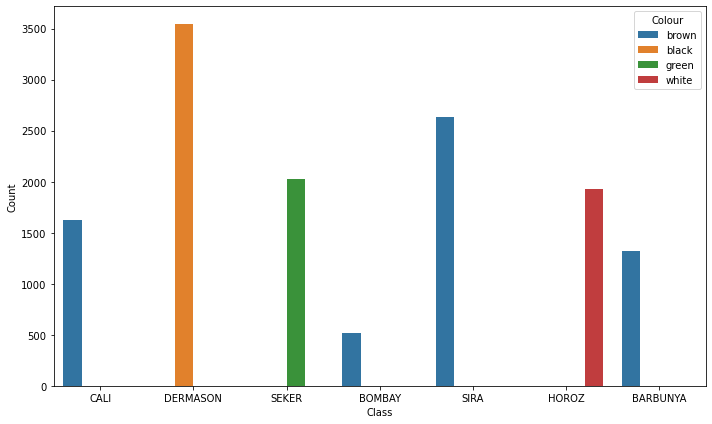

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace with your actual DataFrame)
np.random.seed(0)

# Plot the count plot for each class
plt.figure(figsize=(10, 6))
sns.countplot(data=df[(df.Class != '?') & (df.Colour != '?')], x='Class', hue='Colour')
# plt.title('Count Plot of Colour by Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Colour')
plt.tight_layout()
plt.savefig('Colour_distribution.png')
plt.show()



['BARBUNYA' 'BOMBAY' 'CALI' 'DERMASON' 'HOROZ' 'SEKER' 'SIRA']
      Class Colour  count
0  BARBUNYA  brown   1317
1    BOMBAY  brown    520
2      CALI  brown   1627
3  DERMASON  black   3541
4     HOROZ  white   1926
5     SEKER  green   2023
6      SIRA  brown   2634
Colour     black   brown   green   white
Class                                   
BARBUNYA     0.0  1317.0     0.0     0.0
BOMBAY       0.0   520.0     0.0     0.0
CALI         0.0  1627.0     0.0     0.0
DERMASON  3541.0     0.0     0.0     0.0
HOROZ        0.0     0.0     0.0  1926.0
SEKER        0.0     0.0  2023.0     0.0
SIRA         0.0  2634.0     0.0     0.0
[[1317.    0.    0.    0.]
 [ 520.    0.    0.    0.]
 [1627.    0.    0.    0.]
 [   0. 3541.    0.    0.]
 [   0.    0.    0. 1926.]
 [   0.    0. 2023.    0.]
 [2634.    0.    0.    0.]]


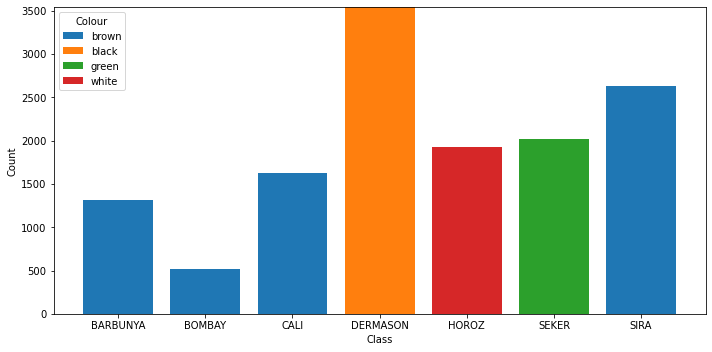

In [4]:
data=df[(df.Class != '?') & (df.Colour != '?')]

categories = np.unique(data.Class)
print(categories)
subcategories = ['brown', 'black', 'green', 'white']

values = data.groupby(['Class', 'Colour']).size().reset_index(name='count')
print(values)
pivot_values = values.pivot(index='Class', columns='Colour', values='count').fillna(0)
print(pivot_values)
plot_values = pivot_values[subcategories].values
print(plot_values)

# Number of categories
ind = np.arange(len(categories))

# Plotting the bars
plt.figure(figsize=(10, 5))
plt.bar(ind, plot_values[:, 0], label=subcategories[0])
plt.bar(ind, plot_values[:, 1], bottom=plot_values[:, 0], label=subcategories[1])
plt.bar(ind, plot_values[:, 2], bottom=plot_values[:, 0] + plot_values[:, 1], label=subcategories[2])
plt.bar(ind, plot_values[:, 3], bottom=plot_values[:, 0] + plot_values[:, 1] + plot_values[:, 2], label=subcategories[3])

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Count')
# plt.title('Stacked Bar Plot of Class vs Colour')
plt.xticks(ind, categories)
plt.legend(loc='upper right')
plt.legend(title='Colour')
plt.tight_layout()
plt.savefig('stacked_colour_distribution.png')

# Show the plot
plt.show()



### Exploring outliers 

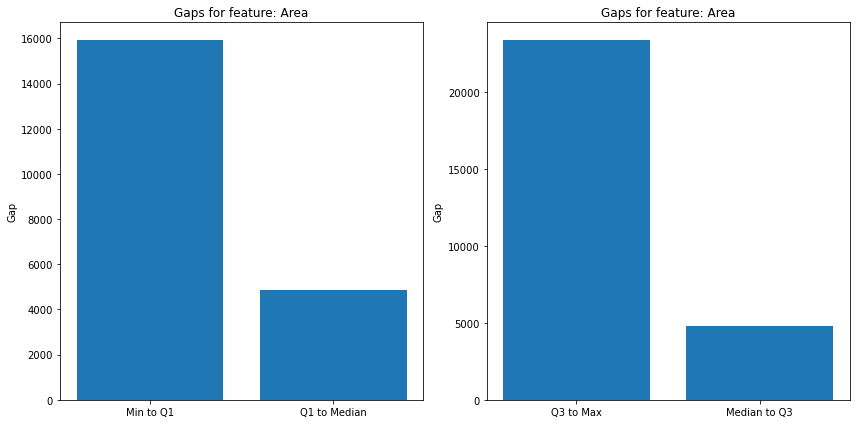

plot saved


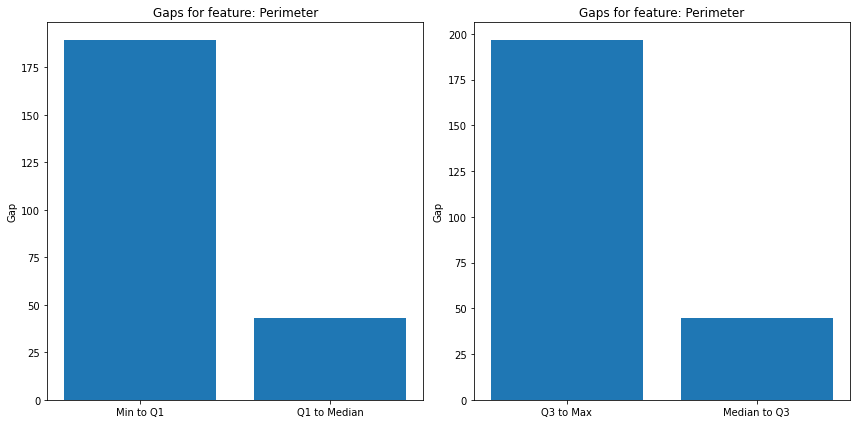

plot saved


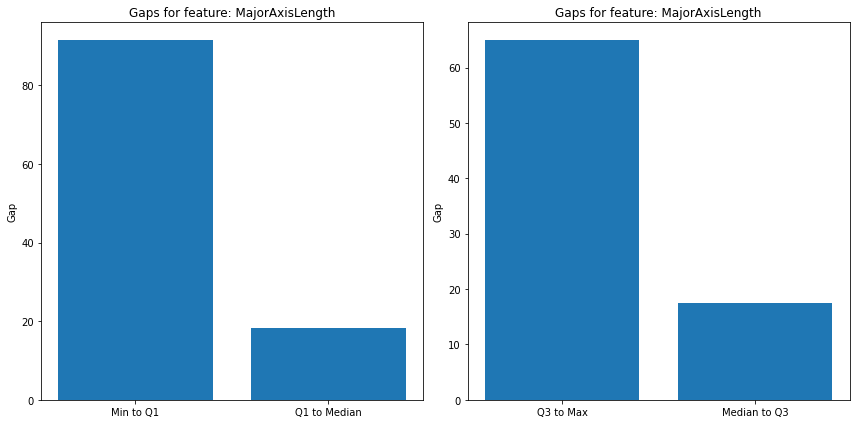

plot saved


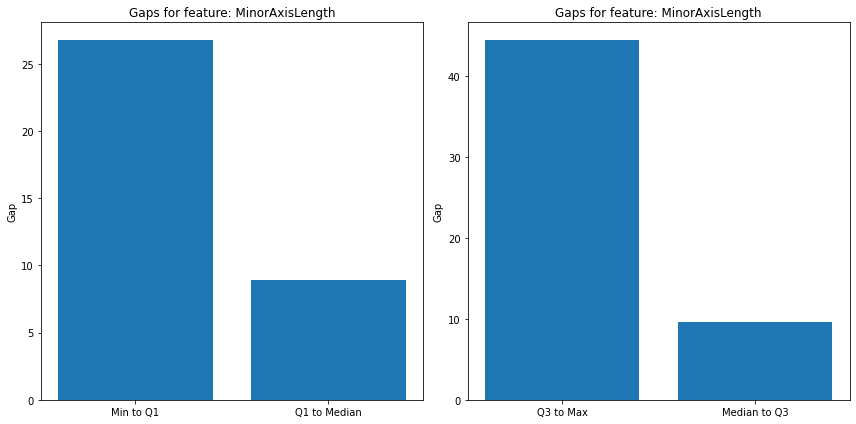

plot saved


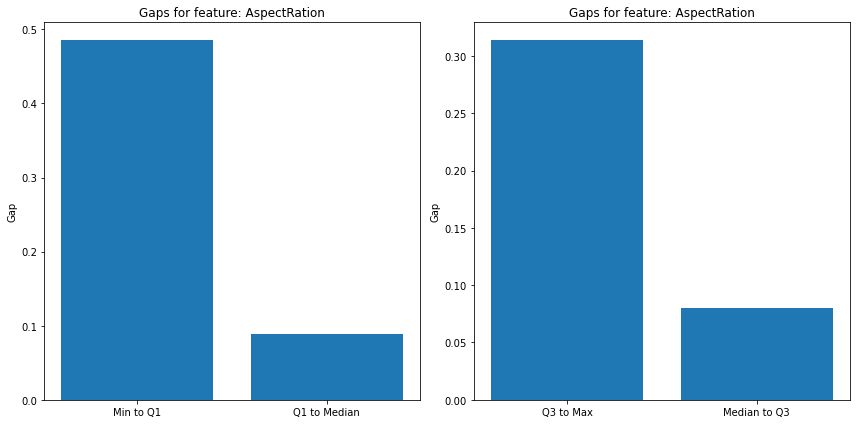

plot saved


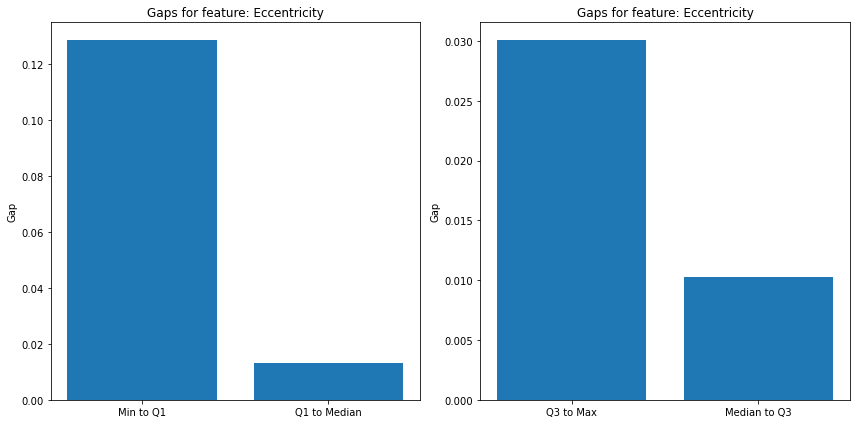

plot saved


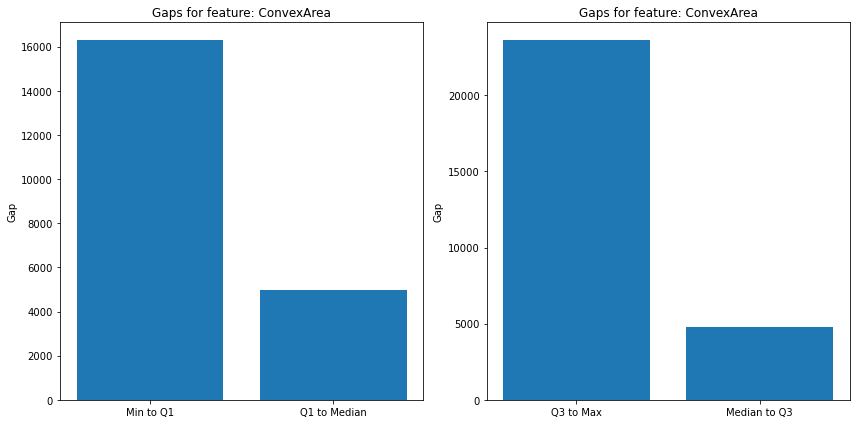

plot saved


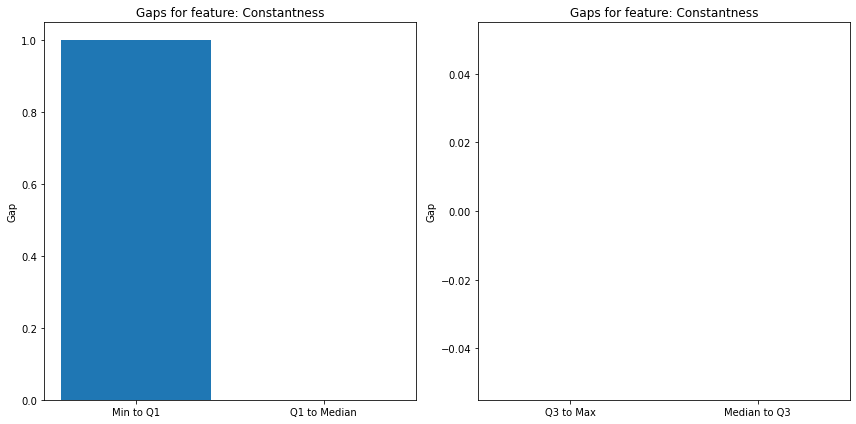

plot saved


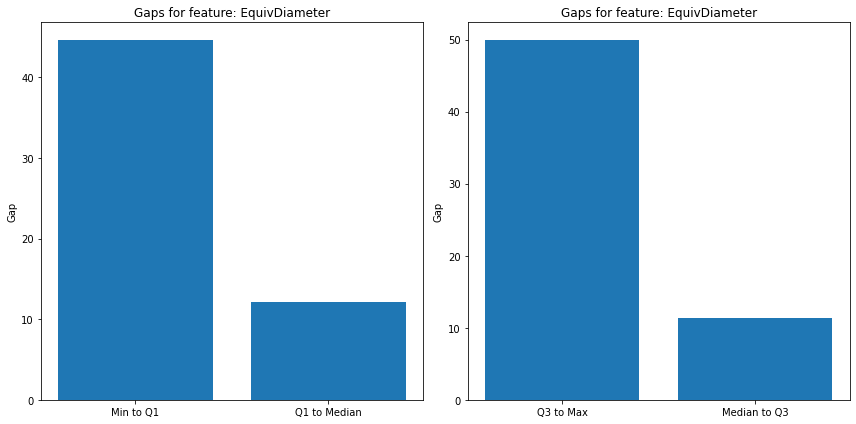

plot saved


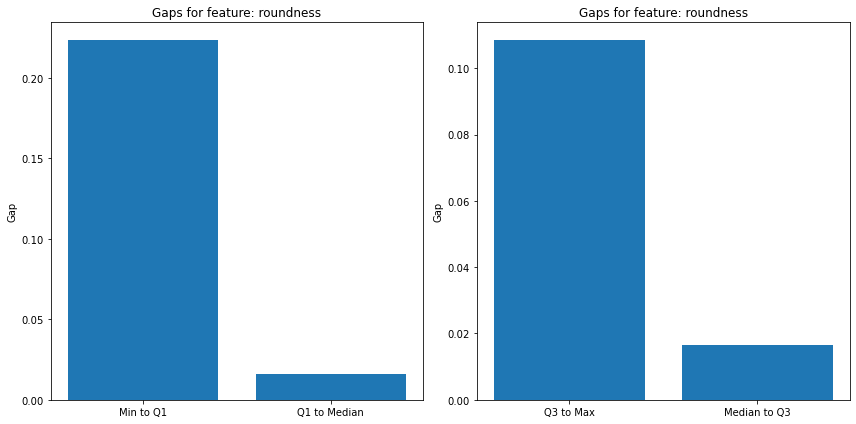

plot saved


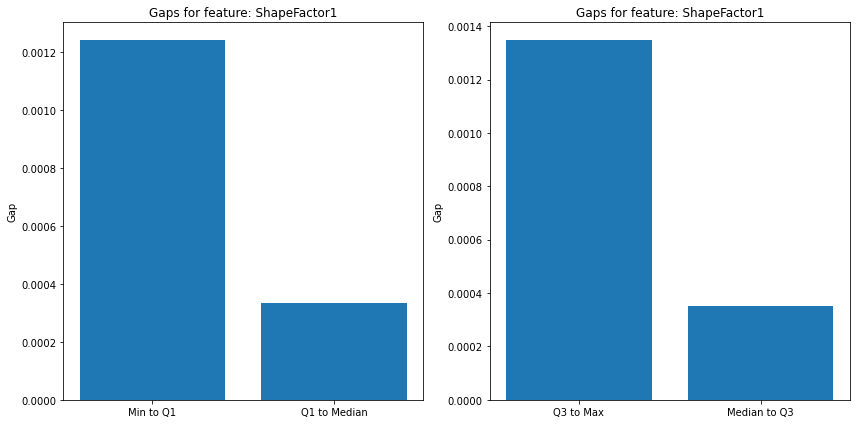

plot saved


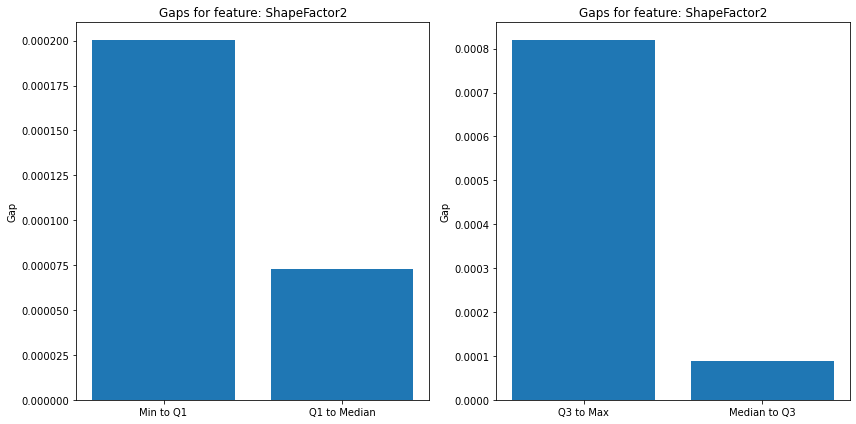

plot saved


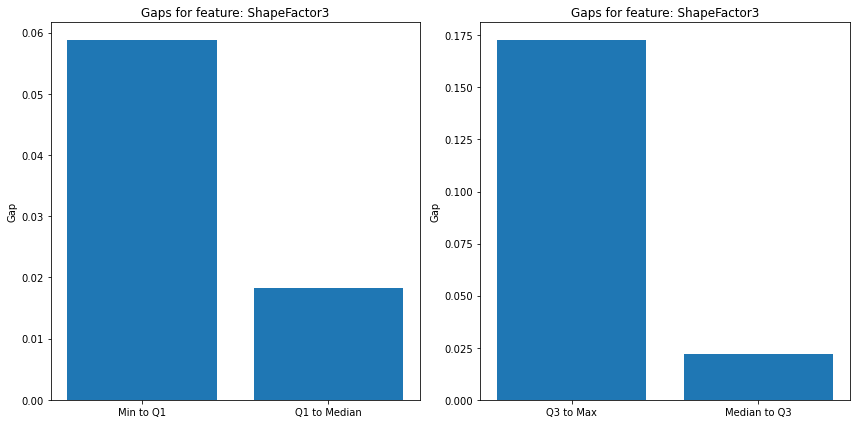

plot saved


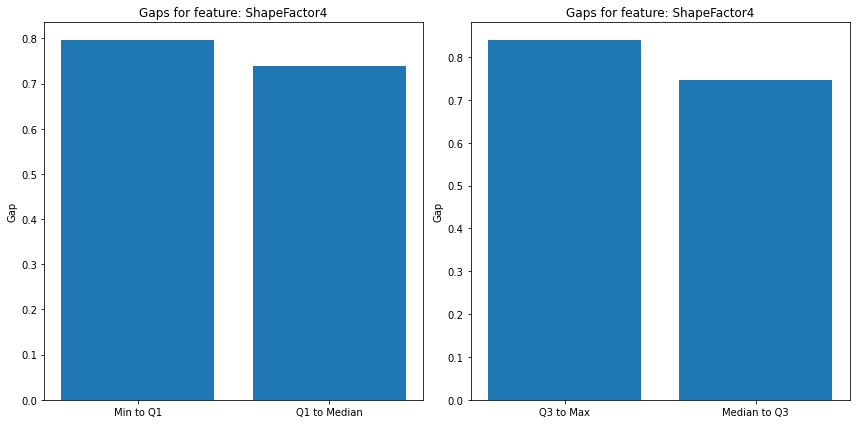

plot saved


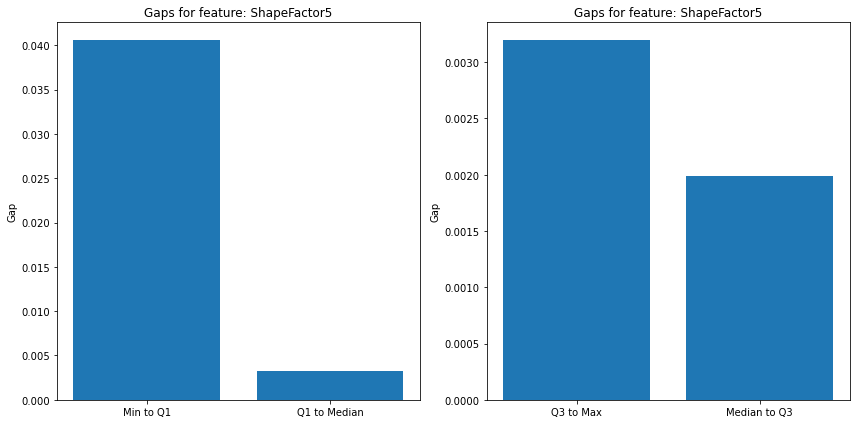

plot saved


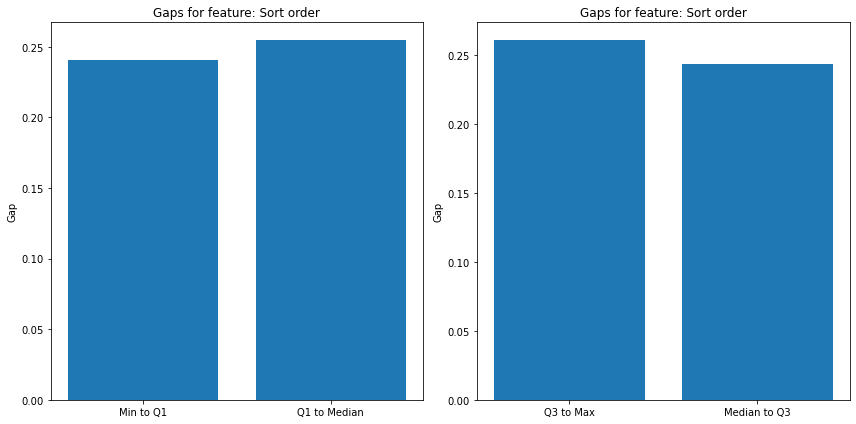

plot saved


In [8]:
df = df[(df.Class == 'HOROZ')]
def range_plot(feature):
    # Calculate quartiles and other statistics

    min_value = df[feature].min()
    q1 = df[feature].quantile(0.25)
    median = df[feature].median()
    q3 = df[feature].quantile(0.75)
    max_value = df[feature].max()

    # Calculate the gaps
    gap_min_q1 = q1 - min_value
    gap_q1_median = median - q1
    gap_q3_max = max_value - q3
    gap_median_q3 = q3 - median

    # Create a bar plot
    gaps1 = {
        'Min to Q1': gap_min_q1,
        'Q1 to Median': gap_q1_median
    }
    
    gaps2 = {
        'Q3 to Max': gap_q3_max,
        'Median to Q3': gap_median_q3
    }

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for the first feature
    axs[0].bar(gaps1.keys(), gaps1.values())
    axs[0].set_title(f'Gaps for feature: {feature}')
    axs[0].set_ylabel('Gap')

    # Plot for the second feature
    axs[1].bar(gaps2.keys(), gaps2.values())
    axs[1].set_title(f'Gaps for feature: {feature}')
    axs[1].set_ylabel('Gap')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.savefig(f'{feature}.jpeg')
    plt.show()
    print('plot saved')
    
    
feature_list = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'Constantness',
       'EquivDiameter', 'roundness',
      'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3',
       'ShapeFactor4', 'ShapeFactor5', 'Sort order']    
 
for column in feature_list:               
    range_plot(column)

- Area: min too small, max too big. 
- Perimeter: min in question, max too big
- MajorAxisLength: min `good`, max too big
- MajorAxisLength: min too small, max too big
- AspectRation: min in queation, max too big
- Eccentricity: min too small, max seems fine
- ConvexArea: min too small, max too big. Contain invalid outlier (noise?)
- EquivDiameter: min too small, max too big
- roundness: min too small, `max good`
- ShapeFactor1: min too small, max too big
- ShapeFactor2: min good, max in question
- ShapeFactor3: min in queation, max too big
- ShapeFactor4: `min good, max good`
- ShapeFactor5: min too small, `max good`
- Sort order: `min good, max good`

## Distribution plots with equal width bars and box plots

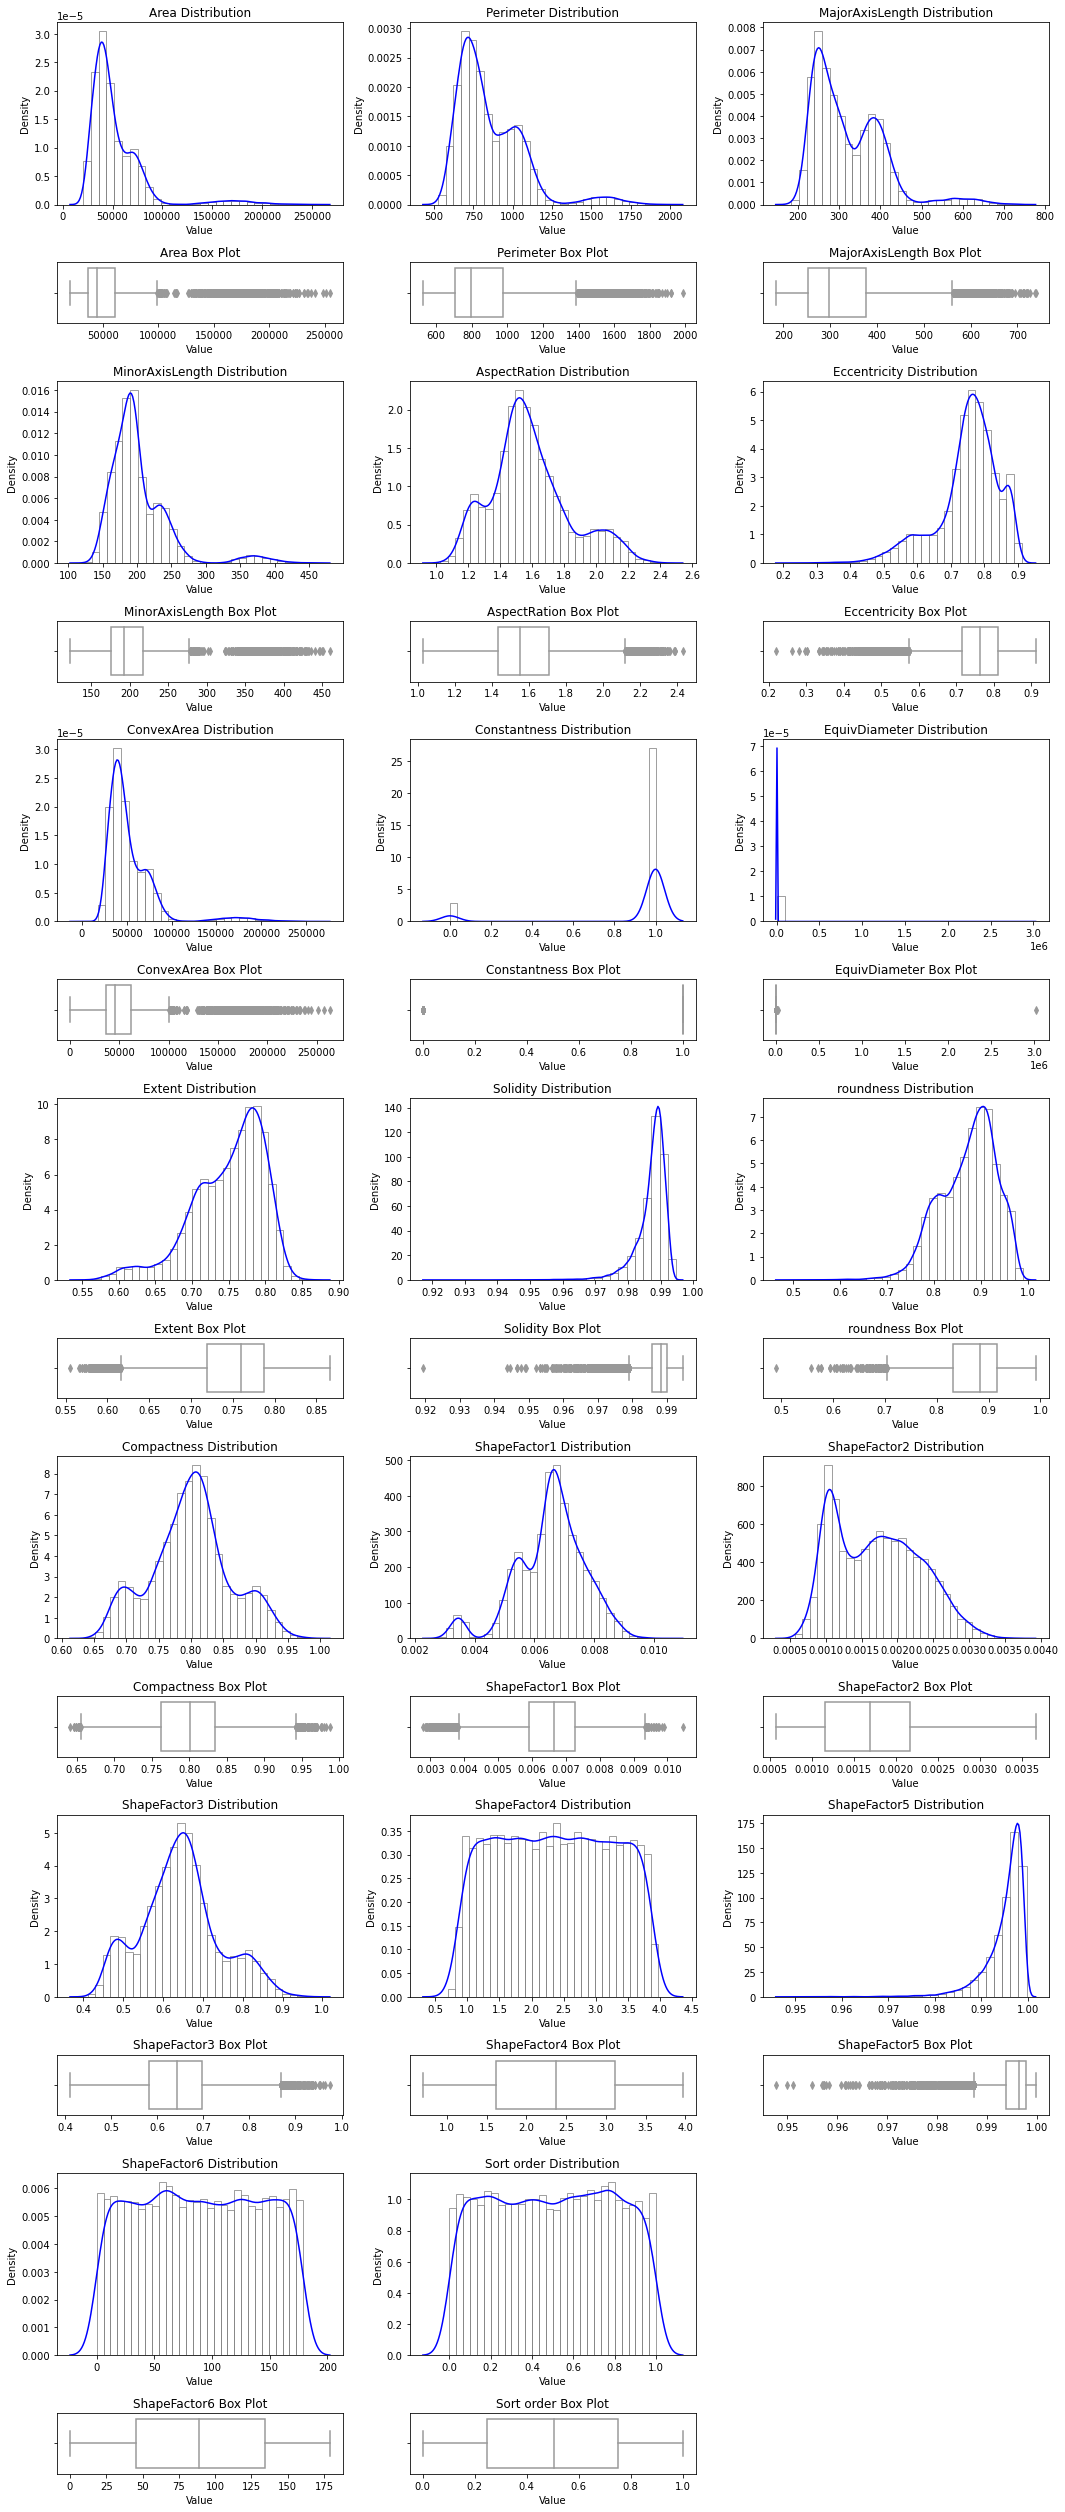

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

# Assuming you've already loaded your DataFrame 'df'

q_df = df.copy()
# q_df = q_df[(df.Class == 'HOROZ')]
# Drop specific columns (if needed)
q_df.drop(columns=['Colour', 'Class'], inplace=True)

# Set number of rows and columns for subplots
num_columns = len(q_df.columns)
rows = 2 * ((num_columns // 3) + (1 if num_columns % 3 != 0 else 0))  # Ensure enough rows for histograms and box plots
cols = min(num_columns, 3)  # Ensure a maximum of 3 columns per row

# Create a figure with subplots
fig = plt.figure(figsize=(15, 5 * (rows // 2)))
# Define the height ratios
height_ratios = [3 if i % 2 == 0 else 1 for i in range(rows)]
gs = gridspec.GridSpec(rows, cols, figure=fig, height_ratios=height_ratios)

# Loop through columns and create histograms with KDE and box plots
for i, (column_name, column) in enumerate(q_df.items()):
    # Filter out rows with '?' and convert to float
    column = column[(column != '?')].astype(float)
    
    # Calculate grid position
    row = (i // cols) * 2
    col = i % cols
    
    # Distribution plot
    ax_hist = fig.add_subplot(gs[row, col])
#     sns.histplot(column, bins=30, kde=False, ax=ax_hist, color='white', edgecolor='black', facecolor='blue')
#     sns.kdeplot(column, ax=ax_hist, color='blue', bw_method=0.001)  # Adjust the bandwidth value

    sns.histplot(column, bins=30, stat="density", fill=False, color ='gray')
    sns.kdeplot(column, color="b")
    ax_hist.set_xlabel('Value')
    ax_hist.set_ylabel('Density')
    ax_hist.set_title(f'{column_name} Distribution')
    
    # Box plot directly underneath
    ax_box = fig.add_subplot(gs[row + 1, col])
    sns.boxplot(x=column, ax=ax_box, orient='h', color='white')
    ax_box.set_xlabel('Value')
    ax_box.set_title(f'{column_name} Box Plot')

# Adjust layout
plt.tight_layout()
plt.savefig('data_distributions_with_boxplots.png')
plt.show()


### Distribution of Colours

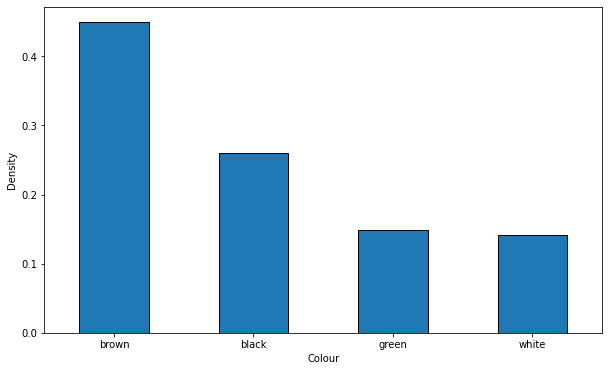

In [5]:
# Calculate the frequency of each category in 'Colour'
# no = df[~(df['Colour'] == '?')]
colour_counts = df[(df.Colour != '?')].Colour.value_counts()

# Normalize the frequencies to get densities
colour_densities = colour_counts / colour_counts.sum()

# Plot the densities using a bar plot
plt.figure(figsize=(10, 6))
colour_densities.plot(kind='bar', edgecolor='black')
plt.xlabel('Colour')
plt.ylabel('Density')
# plt.title('Density Plot of Colour')
plt.xticks(rotation=0) 
plt.show()

### Distribution of Class labels

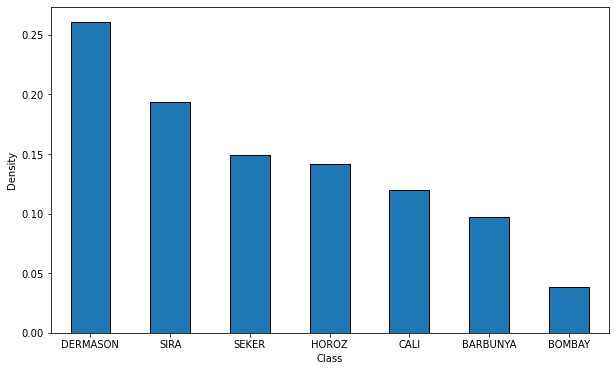

In [6]:
# Calculate the frequency of each category in 'Colour'
# no = df[~(df['Colour'] == '?')]
colour_counts = df[(df.Class != '?')].Class.value_counts()

# Normalize the frequencies to get densities
colour_densities = colour_counts / colour_counts.sum()

# Plot the densities using a bar plot
plt.figure(figsize=(10, 6))
colour_densities.plot(kind='bar', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Density')
# plt.title('Density Plot of Class')
plt.xticks(rotation=0) 
plt.show()

## Remove invalid outliers 

### EquivDiameter

In [4]:
sum = 0
for i in range(2):
    sum += max(df.EquivDiameter)
    df=df[(df.EquivDiameter < max(df.EquivDiameter))]

print('average of the 2 values, ',  sum/2)
print(max(df.EquivDiameter))

average of the 2 values,  1519270.7953754915
569.374358328761


In [5]:
np.mean(df.EquivDiameter)

253.04967635122424

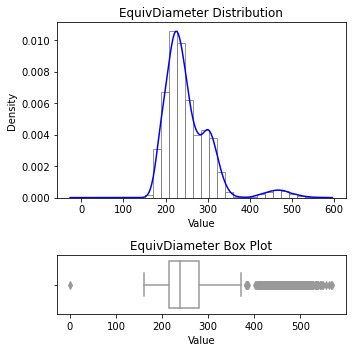

In [6]:
from matplotlib import gridspec

column_name = 'EquivDiameter'
column = df['EquivDiameter']

# Initialize the figure with a specific size
fig = plt.figure(figsize=(5, 5))

# Create a GridSpec with two rows and one column, with different height ratios
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], figure=fig)

# Distribution plot (Histogram + KDE)
ax_hist = fig.add_subplot(gs[0, 0])
sns.histplot(column, bins=30, stat="density", fill=False, color='gray')
sns.kdeplot(column, color="blue")
ax_hist.set_xlabel('Value')
ax_hist.set_ylabel('Density')
ax_hist.set_title(f'{column_name} Distribution')

# Box plot directly underneath
ax_box = fig.add_subplot(gs[1, 0])
sns.boxplot(x=column, ax=ax_box, orient='h', color='white')
ax_box.set_xlabel('Value')
ax_box.set_title(f'{column_name} Box Plot')

# Adjust the layout to ensure no overlap
plt.tight_layout()

# Save the figure
plt.savefig('equivdiameter_distributions_with_boxplots.png')

# Display the plot
plt.show()

In [7]:
print(min(df.EquivDiameter))
df=df[(df.EquivDiameter > min(df.EquivDiameter))]
print(min(df.EquivDiameter))

0.161417390771442
161.24376423134


### ConvexArea

In [8]:
print(min(df.ConvexArea))
df=df[(df.ConvexArea > min(df.ConvexArea))]
print(min(df.ConvexArea))

-30
20684


## Handeling missing values
- Use the clean dataset for this but it is not necessary to throw away all of the rows
    - impute colour from the class label
    - impute the other values from the median of the class label

### Colour

In [9]:
# Define the function to change colour based on conditions
def change_colour(row):
    if row['Colour'] == '?' and row['Class'] == 'SEKER':
        row['Colour'] = 'green'
    elif row['Colour'] == '?' and row['Class'] == 'HOROZ':
        row['Colour'] = 'white'
    elif row['Colour'] == '?' and row['Class'] == 'DERMASON':
        row['Colour'] = 'black'
    elif row['Colour'] == '?':
        row['Colour'] = 'brown'
    return row

# Apply the function to the DataFrame
df = df.apply(change_colour, axis=1) 

### Class

In [10]:
df_labeled = df[df['Class'] !='?']
df_unlabeled = df[df['Class']== '?']

In [11]:
## Assign class labels
index_to_label = df_unlabeled.index[[1, 2]]  # 10 for the 11th row in zero-based indexing

# Assign the new class label to the specific instance
df_unlabeled.loc[index_to_label, 'Class'] = 'SIRA'

index_to_label = df_unlabeled.index[13]  # 10 for the 11th row in zero-based indexing

# Assign the new class label to the specific instance
df_unlabeled.loc[index_to_label, 'Class'] = 'BOMBAY'

# Create a boolean mask to drop the 14th row by position
index_to_drop = df_unlabeled.index[[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16]]  # 13 for 14th row in zero-based indexing

# Drop the row with the identified index
df_unlabeled = df_unlabeled.drop(index_to_drop)

df_unlabeled
# Concatenate along rows (default behavior)
df = pd.concat([df_unlabeled, df_labeled], ignore_index=True)

In [12]:
df_dt = df.copy()
df_knn = df.copy()

In [13]:
print(df_dt.shape[0])
print(df_knn.shape[0])

13593
13593


In [14]:
df_missing = df[(df.Compactness == '?') +
          (df.Extent == '?')+
         (df.Colour == '?') + 
         (df.ShapeFactor6 == '?') +
         (df.Class == '?')]
df_missing.head()

Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
106   48479    836.757       312.354576       199.059288      1.569153   
484   76489   1079.856       423.766238       234.103967      1.810163   
788   56433    948.827       381.693063       191.664022      1.991470   
902   33128    672.417       249.492034       169.302978      1.473642   
1242  43407    766.597       267.183501       207.399654      1.288254   

      Eccentricity  ConvexArea  Constantness  EquivDiameter Colour  ...  \
106       0.770627       49080             0     248.445930  brown  ...   
484       0.833555       78182             0     312.071818  brown  ...   
788       0.864785       57627             1     268.053590  white  ...   
902       0.734517       33481             1     205.377408  black  ...   
1242      0.630432       43864             1     235.090427  green  ...   

     roundness  Compactness  ShapeFactor1 ShapeFactor2  ShapeFactor3  \
106   0.870091            ?      0.006443     0.001591      0.632657   
484   0.824285            ?      0.005540     0.001005      0.542321   
788   0.787715            ?      0.006764     0.001015      0.493191   
902   0.920720            ?      0.007531     0.002133      0.677629   
1242  0.928187            ?      0.006155     0.002276      0.774195   

      ShapeFactor4  ShapeFactor5  ShapeFactor6     Class Sort order  
106       2.705577      0.992735     99.847826      SIRA   0.923518  
484       2.856135      0.981689    103.156493      CALI   0.942229  
788       2.034846      0.982174     72.216663     HOROZ   0.437256  
902       2.626517      0.998583     93.499108  DERMASON   0.037087  
1242      2.230308      0.997361     20.488472     SEKER   0.394059  

[5 rows x 22 columns]

In [15]:
df_clean = df[(df.Compactness != '?') &
          (df.Extent != '?')&
         (df.Colour != '?') & 
         (df.ShapeFactor6 != '?') & 
         (df.Class != '?')]
df_clean.shape

(13564, 22)

### Continious features 

#### Extent

In [14]:
df[df['Extent'] != '?'].groupby('Class')['Extent'].median()

Class
BARBUNYA    0.750701
BOMBAY      0.783777
CALI        0.765897
DERMASON    0.753975
HOROZ       0.703995
SEKER       0.774197
SIRA        0.752380
Name: Extent, dtype: float64

In [15]:
medians = df[df['Extent'] != '?'].groupby('Class')['Extent'].median()

def impute_extent(row):
    if row['Extent'] == '?':
        return medians[row['Class']]
    else:
        return row['Extent']

df_knn['Extent'] = df_knn.apply(impute_extent, axis=1)

df_knn['Extent'] = df_knn['Extent'].astype(float)


#### Compactness

In [16]:
medians = df[df['Compactness'] != '?'].groupby('Class')['Compactness'].median()

def impute_extent(row):
    if row['Compactness'] == '?':
        return medians[row['Class']]
    else:
        return row['Compactness']

df_knn['Compactness'] = df_knn.apply(impute_extent, axis=1)

df_knn['Compactness'] = df_knn['Compactness'].astype(float)


#### ShapeFactor6

In [17]:
medians = df[df['ShapeFactor6'] != '?'].groupby('Class')['ShapeFactor6'].median()

def impute_extent(row):
    if row['ShapeFactor6'] == '?':
        return medians[row['Class']]
    else:
        return row['ShapeFactor6']

df_knn['ShapeFactor6'] = df_knn.apply(impute_extent, axis=1)

df_knn['ShapeFactor6'] = df_knn['ShapeFactor6'].astype(float)


### Class

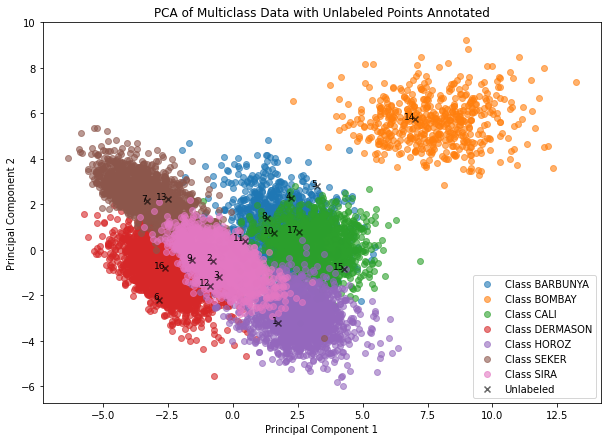

In [17]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df_labeled = df_knn[df_knn['Class'] !='?']
df_unlabeled = df_knn[df_knn['Class']== '?']

# Features
X_labeled = df_labeled.drop(columns=['Class', 'Colour'])
X_unlabeled = df_unlabeled.drop(columns=['Class', 'Colour'])

# Scaling
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

# PCA
pca = PCA(n_components=2)
X_labeled_pca = pca.fit_transform(X_labeled_scaled)
X_unlabeled_pca = pca.transform(X_unlabeled_scaled)

# Plotting
plt.figure(figsize=(10, 7))
for label in np.unique(df_labeled['Class']):
    indices = df_labeled['Class'] == label
    plt.scatter(X_labeled_pca[indices, 0], X_labeled_pca[indices, 1], label=f'Class {label}', alpha=0.6)

plt.scatter(X_unlabeled_pca[:, 0], X_unlabeled_pca[:, 1], color='black', label='Unlabeled', alpha=0.6, marker='x')

# Label the unlabeled points with small integers
for i, (x, y) in enumerate(X_unlabeled_pca):
    plt.text(x, y, str(i+1), fontsize=9, ha='right')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Multiclass Data with Unlabeled Points Annotated')
plt.legend()
plt.show()

In [18]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Assume df is your DataFrame with a 'Class' column
df_labeled = df_knn[df_knn['Class'] != '?']
df_unlabeled = df_knn[df_knn['Class'] == '?']

# Features
X_labeled = df_labeled.drop(columns=['Class', 'Colour', 'Constantness'])
X_unlabeled = df_unlabeled.drop(columns=['Class', 'Colour', 'Constantness'])

# Scaling
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

# PCA with 3 components for 3D plotting
pca = PCA(n_components=3)
X_labeled_pca = pca.fit_transform(X_labeled_scaled)
X_unlabeled_pca = pca.transform(X_unlabeled_scaled)

# Create a 3D scatter plot
fig = make_subplots(specs=[[{'type': 'scatter3d'}]])

# Plot the labeled data
for label in np.unique(df_labeled['Class']):
    indices = df_labeled['Class'] == label
    fig.add_trace(go.Scatter3d(
        x=X_labeled_pca[indices, 0],
        y=X_labeled_pca[indices, 1],
        z=X_labeled_pca[indices, 2],
        mode='markers',
        marker=dict(size=5),
        name=f'Class {label}'
    ))

# Plot the unlabeled data with annotations
fig.add_trace(go.Scatter3d(
    x=X_unlabeled_pca[:, 0],
    y=X_unlabeled_pca[:, 1],
    z=X_unlabeled_pca[:, 2],
    mode='markers+text',
    marker=dict(size=7, color='black'),
    text=[str(i + 1) for i in range(X_unlabeled_pca.shape[0])],
    textposition='top center',
    name='Unlabeled'
))

# Update layout
fig.update_layout(
    title='3D PCA of Multiclass Data with Unlabeled Points Annotated',
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    legend_title_text='Class'
)

fig.show()


The is not sufficient information to make an assumption about which class the entries belong to. By using the colour column a set of possible classes can be identified, however an accurate imputation can not be done.


# Outliers

## Removing valid outliers 

### Identify and clamp (did not use)

In [116]:
import numpy as np

# Define the adjusted box plot fences function
def adjusted_box_plot_fences(column):
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound


class_column = 'Class'

# Iterate through each class in the dataset
for class_label in df[class_column].unique():
    
    # Filter the DataFrame by class
    class_data = df[df[class_column] == class_label]
    
    # Iterate through each feature in the class-specific data
    for column in class_data.columns:
        if column in([class_column, 'Constantness', 'Colour']):
            continue 
        
        feature_data = class_data[column].values.reshape(-1, 1)
        
        # Apply adjusted box plot for outlier detection
        lower_bound, upper_bound = adjusted_box_plot_fences(feature_data)
        
        # Identify outliers
        outliers = (feature_data < lower_bound) | (feature_data > upper_bound)
        
        # Clamp outliers to the boundary values
        feature_data[outliers] = np.clip(feature_data[outliers], lower_bound, upper_bound)
        
        # Update the original DataFrame with the clamped data
        df.loc[df[class_column] == class_label, column] = feature_data.flatten()

        print(f"Class {class_label} - Feature {column}:")
        print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
        print(f"Number of clamped outliers: {outliers.sum()}\n")


Class CALI - Feature Area:
Lower Bound: 51383.125, Upper Bound: 99280.125
Number of clamped outliers: 29

Class CALI - Feature Perimeter:
Lower Bound: 884.4131250000002, Upper Bound: 1231.3541249999998
Number of clamped outliers: 26

Class CALI - Feature MajorAxisLength:
Lower Bound: 334.7065576679225, Upper Bound: 484.30006127117855
Number of clamped outliers: 20

Class CALI - Feature MinorAxisLength:
Lower Bound: 199.63788800754853, Upper Bound: 272.2315603363145
Number of clamped outliers: 38

Class CALI - Feature AspectRation:
Lower Bound: 1.4965601135248159, Upper Bound: 1.9715253510464663
Number of clamped outliers: 23

Class CALI - Feature Eccentricity:
Lower Bound: 0.7601890051847724, Upper Bound: 0.8720666144781146
Number of clamped outliers: 30

Class CALI - Feature ConvexArea:
Lower Bound: 51974.875, Upper Bound: 100829.875
Number of clamped outliers: 28

Class CALI - Feature EquivDiameter:
Lower Bound: 260.1895208651573, Upper Bound: 358.72404217586643
Number of clamped out

Class HOROZ - Feature ShapeFactor1:
Lower Bound: 0.005611850894140916, Upper Bound: 0.008358203498415418
Number of clamped outliers: 13

Class HOROZ - Feature ShapeFactor2:
Lower Bound: 0.0007082428753142362, Upper Bound: 0.0013553115881142265
Number of clamped outliers: 73

Class HOROZ - Feature ShapeFactor3:
Lower Bound: 0.4085764733479665, Upper Bound: 0.5698547091226984
Number of clamped outliers: 55

Class HOROZ - Feature ShapeFactor4:
Lower Bound: -0.7021173229377078, Upper Bound: 5.242293545438433
Number of clamped outliers: 0

Class HOROZ - Feature ShapeFactor5:
Lower Bound: 0.9826585793144811, Upper Bound: 1.003720264474385
Number of clamped outliers: 144

Class HOROZ - Feature ShapeFactor6:
Lower Bound: -93.77558162401738, Upper Bound: 271.98800295767285
Number of clamped outliers: 0

Class HOROZ - Feature Sort order:
Lower Bound: -0.5066476757629796, Upper Bound: 1.4864461902972486
Number of clamped outliers: 0

Class BARBUNYA - Feature Area:
Lower Bound: 42834.875, Upper Bo

### Balanced classes

In [65]:
import pandas as pd
from sklearn.utils import resample

class_counts = df['Class'].value_counts()
min_class_size = class_counts.min()

undersampled_dfs = []

for label in class_counts.index:
    class_df = df[df['Class'] == label]
    undersampled_class_df = resample(class_df, replace=False, n_samples=min_class_size, random_state=42)
    undersampled_dfs.append(undersampled_class_df)

undersampled_df = pd.concat(undersampled_dfs)

print(undersampled_df['Class'].value_counts())

DERMASON    521
SIRA        521
SEKER       521
HOROZ       521
CALI        521
BARBUNYA    521
BOMBAY      521
Name: Class, dtype: int64


## Creating the Classifier models

### Encoding Categorical Features

In [49]:
X_encoded_dt = pd.get_dummies(df_dt, columns=['Colour'], drop_first=False)
X_encoded_knn = pd.get_dummies(df_knn, columns=['Colour'], drop_first=False)

### Splitting the data 

In [50]:
X_dt = X_encoded_dt.drop(['Class'], axis=1)
y_dt = df_dt['Class']

X_knn = X_encoded_knn.drop(['Class'], axis=1)
y_knn = df_knn['Class']


# For Decision Tree
#Split into 70% training and 30% temporary (15% test + 15% validation)
X_train_dt, X_temp_dt, y_train_dt, y_temp_dt = train_test_split(X_dt, y_dt, test_size=0.30, random_state=42)

#Split the temporary set into 15% test and 15% validation
X_test_dt, X_val_dt, y_test_dt, y_val_dt = train_test_split(X_temp_dt, y_temp_dt, test_size=0.50, random_state=42)

# For KNN
#Split into 70% training and 30% temporary (15% test + 15% validation)
X_train_knn, X_temp_knn, y_train_knn, y_temp_knn = train_test_split(X_knn, y_knn, test_size=0.30, random_state=42)

#Split the temporary set into 15% test and 15% validation
X_test_knn, X_val_knn, y_test_knn, y_val_knn = train_test_split(X_temp_knn, y_temp_knn, test_size=0.50, random_state=42)


In [51]:
print(y_train_dt.value_counts())
print(y_train_knn.value_counts())

DERMASON    2444
SIRA        1865
SEKER       1440
HOROZ       1348
CALI        1140
BARBUNYA     920
BOMBAY       358
Name: Class, dtype: int64
DERMASON    2444
SIRA        1865
SEKER       1440
HOROZ       1348
CALI        1140
BARBUNYA     920
BOMBAY       358
Name: Class, dtype: int64


In [52]:
X_train_dt[X_train_dt['Extent'] == '?']


Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
2823  32151    683.765       256.447023       160.189394      1.600899   
5111  70644   1035.229       389.680282       236.319677      1.648954   
5983  33946    667.313       231.542540       187.028992      1.238003   
5831  45828    793.385       293.291919       199.306966      1.471559   
2822  51484    908.819       362.407122       181.452230      1.997259   
6665  49640    880.815       344.182643       184.789184      1.862569   

      Eccentricity  ConvexArea  Constantness  EquivDiameter Extent  ...  \
2823      0.780906       32479             0     202.326283      ?  ...   
5111      0.795125       72782             1     299.911211      ?  ...   
5983      0.589522       34246             1     207.897546      ?  ...   
5831      0.733628       46273             1     241.557492      ?  ...   
2822      0.865629       52533             1     256.030203      ?  ...   
6665      0.843650       50388             1     251.403284      ?  ...   

      ShapeFactor2  ShapeFactor3 ShapeFactor4  ShapeFactor5  ShapeFactor6  \
2823      0.001906      0.622457     2.104688      0.996491    148.223792   
5111      0.001194      0.592337     2.235719      0.976736     93.745222   
5983      0.002735      0.806190     1.363311      0.998065    166.640782   
5831      0.001816      0.678330     3.835676      0.998202    172.789151   
2822      0.001082      0.499102     2.256730      0.996835     23.610466   
6665      0.001217      0.533536     1.136485      0.993748      51.51274   

      Sort order  Colour_black  Colour_brown Colour_green  Colour_white  
2823    0.900319             1             0            0             0  
5111    0.301322             0             1            0             0  
5983    0.277024             0             0            1             0  
5831    0.514507             0             1            0             0  
2822    0.542473             0             0            0             1  
6665    0.762206             0             0            0             1  

[6 rows x 24 columns]

In [53]:
from sklearn.preprocessing import LabelEncoder

# Create and fit the label encoder
label_encoder = LabelEncoder()
y_train_knn = label_encoder.fit_transform(y_train_knn)
y_test_knn = label_encoder.transform(y_test_knn)
y_val_knn = label_encoder.transform(y_val_knn)

y_train_dt = label_encoder.fit_transform(y_train_dt)
y_test_dt = label_encoder.transform(y_test_dt)
y_val_dt = label_encoder.transform(y_val_dt)


## SMOTE

In [54]:
# Applying SMOTE
smote_tomek = SMOTETomek(random_state=42)
X_train_dt.replace('?', -999, inplace=True)

X_train_res_dt, y_train_res_dt = smote_tomek.fit_resample(X_train_dt, y_train_dt)

# Restore missing values in the training data
X_train_res_dt.replace(-999, np.nan, inplace=True)
X_train_dt.replace(-999, np.nan, inplace=True)

# y_train_dt.value_counts()

print(f"Original dataset shape (dt): {y_train_dt.shape}")
print(f"Resampled dataset shape (dt): {y_train_res_dt.shape}")


X_val_dt.replace('?', np.nan, inplace=True)


# knn dataset
X_train_res_knn, y_train_res_knn = smote_tomek.fit_resample(X_train_knn, y_train_knn)

# y_train_knn.value_counts()

print(f"Original dataset shape (knn): {y_train_knn.shape}")
print(f"Resampled dataset shape (knn): {y_train_res_knn.shape}")

Original dataset shape (dt): (9515,)
Resampled dataset shape (dt): (16368,)
Original dataset shape (knn): (9515,)
Resampled dataset shape (knn): (16364,)


In [37]:
# Calculate the frequency of each category in 'Colour'
colour_counts = y_train_res_dt.value_counts()

# Normalize the frequencies to get densities
colour_densities = colour_counts / colour_counts.sum()

# Plot the densities using a bar plot
plt.figure(figsize=(10, 6))
colour_densities.plot(kind='bar', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Density')
# plt.title('Density Plot of Class')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

## Scaling the data 

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_res_knn = scaler.fit_transform(X_train_res_knn)
X_train_knn = scaler.transform(X_train_knn)
X_val_knn = scaler.transform(X_val_knn)

### Decision tree classifier 

In [25]:
DT = DecisionTreeClassifier()
DT.fit(X_train_res_dt, y_train_res_dt)

y_pred = DT.predict(X_val_dt)
print(classification_report(y_pred, y_val_dt))
print(accuracy_score(y_pred, y_val_dt))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       198
           1       1.00      1.00      1.00        88
           2       0.92      0.94      0.93       248
           3       1.00      1.00      1.00       549
           4       1.00      1.00      1.00       277
           5       1.00      1.00      1.00       294
           6       0.97      0.97      0.97       385

    accuracy                           0.98      2039
   macro avg       0.97      0.97      0.97      2039
weighted avg       0.98      0.98      0.98      2039

0.9769494850416871


In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1, 1.0],
}

grid_search = GridSearchCV(estimator=DT, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res_dt, y_train_res_dt)


print(f"Best parameters: {grid_search.best_params_}")

best_DT = grid_search.best_estimator_

y_pred = best_DT.predict(X_val_dt)
print(classification_report(y_pred, y_val_dt))
print(accuracy_score(y_pred, y_val_dt))


Fitting 10 folds for each of 750 candidates, totalling 7500 fits
Best parameters: {'ccp_alpha': 0.0, 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       199
           1       1.00      1.00      1.00        88
           2       0.92      0.96      0.94       243
           3       1.00      1.00      1.00       549
           4       1.00      1.00      1.00       277
           5       1.00      1.00      1.00       294
           6       0.98      0.97      0.97       389

    accuracy                           0.98      2039
   macro avg       0.97      0.97      0.97      2039
weighted avg       0.98      0.98      0.98      2039

0.9779303580186366


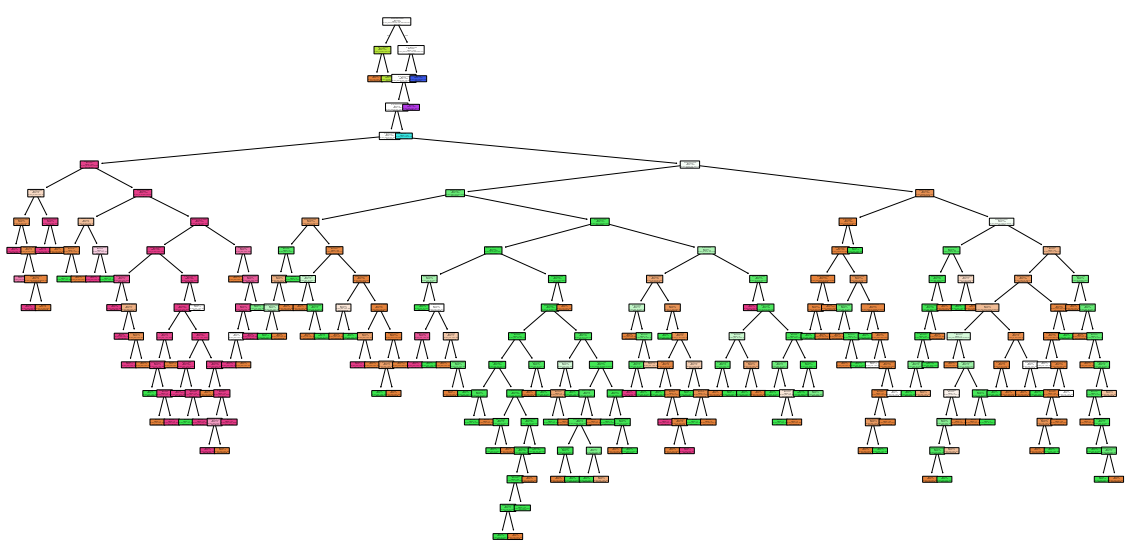

In [35]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(best_DT, filled=True, rounded=True, feature_names=X_train_res_dt.columns, class_names=['DERMASON','SIRA', 'SEKER','HOROZ', 'CALI', 'BARBUNYA', 'BOMBAY'])
plt.show()


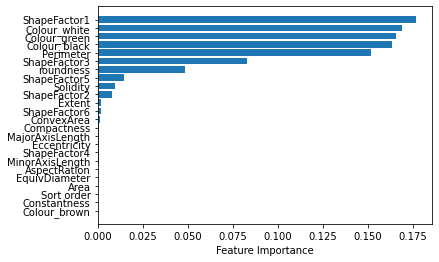

In [36]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = best_DT.feature_importances_
sorted_idx = np.argsort(feature_importances)
plt.barh(np.array(X_train_dt.columns)[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.show()


## k-Nearest Neigbors

In [27]:
knn = KNeighborsClassifier(25)
knn.fit(X_train_res_knn, y_train_res_knn)

y_pred = knn.predict(X_val_knn)

print(classification_report(y_pred, y_val_knn))
print(accuracy_score(y_pred, y_val_knn))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       175
           1       1.00      1.00      1.00        88
           2       0.95      0.92      0.94       262
           3       1.00      1.00      1.00       549
           4       1.00      1.00      1.00       278
           5       1.00      1.00      1.00       294
           6       0.98      0.96      0.97       393

    accuracy                           0.98      2039
   macro avg       0.97      0.98      0.97      2039
weighted avg       0.98      0.98      0.98      2039

0.9769494850416871


# Getting optimal number for k

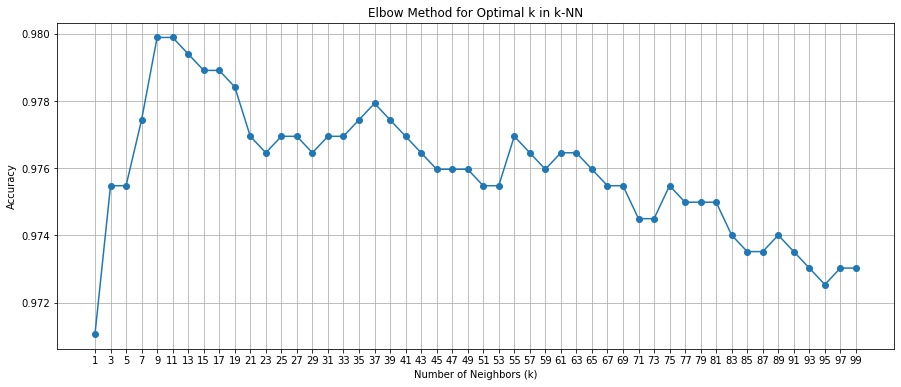

In [34]:
# Range of k values to test
k_values = range(1, 100, 2) 
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_res_knn, y_train_res_knn)
    y_pred = knn.predict(X_val_knn)
    accuracy = accuracy_score(y_val_knn, y_pred)
    accuracies.append(accuracy)

# Plot the elbow diagram
plt.figure(figsize=(15, 6))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Elbow Method for Optimal k in k-NN')
plt.xticks(k_values)
plt.grid(True)
plt.show()

## Grid search 

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': range(3, 31, 2),
    'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming', 'chebyshev', 'braycurtis'],
     'p': [3] 
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res_knn, y_train_res_knn)

print(f"Best parameters: {grid_search.best_params_}")
knn_best = grid_search.best_estimator_


Fitting 10 folds for each of 98 candidates, totalling 980 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 3}


In [31]:
y_pred = knn_best.predict(X_val_knn)

print(classification_report(y_pred, y_val_knn))
print(accuracy_score(y_pred, y_val_knn))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       186
           1       1.00      1.00      1.00        88
           2       0.93      0.93      0.93       253
           3       1.00      1.00      1.00       549
           4       1.00      1.00      1.00       276
           5       1.00      1.00      1.00       294
           6       0.99      0.97      0.98       393

    accuracy                           0.98      2039
   macro avg       0.97      0.97      0.97      2039
weighted avg       0.98      0.98      0.98      2039

0.9764590485532123


## Using McNemar test to evaluate the performance of 2 different  models (primarily binary)

In [37]:
from statsmodels.stats.contingency_tables import mcnemar

# Train Model 1: DT
model1 = DecisionTreeClassifier(ccp_alpha= 0.0, max_depth= 40, min_samples_leaf= 1, min_samples_split= 5)
model1.fit(X_train_res_knn, y_train_res_knn)
y_pred1 = model1.predict(X_val_knn)

# Train Model 2: KNN
model2 = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 3, p= 3)
model2.fit(X_train_res_knn, y_train_res_knn)
y_pred2 = model2.predict(X_val_knn)

# Calculate accuracy for both models
accuracy_model1 = accuracy_score(y_val_knn, y_pred1)
accuracy_model2 = accuracy_score(y_val_knn, y_pred2)
print(f"Accuracy of Model 1: {accuracy_model1:.4f}")
print(f"Accuracy of Model 2: {accuracy_model2:.4f}")

# Create the contingency table
contingency_table = np.array([[np.sum((y_pred1 == y_val_knn) & (y_pred2 == y_val_knn)),
                               np.sum((y_pred1 == y_val_knn) & (y_pred2 != y_val_knn))],
                              [np.sum((y_pred1 != y_val_knn) & (y_pred2 == y_val_knn)),
                               np.sum((y_pred1 != y_val_knn) & (y_pred2 != y_val_knn))]])

print("\nContingency Table:")
print(contingency_table)

# Apply McNemar's test
result = mcnemar(contingency_table, exact=True)
print(f"\nMcNemar Test Statistic: {result.statistic}")
print(f"p-value: {result.pvalue}")

# Interpret the result
alpha = 0.05
if result.pvalue < alpha:
    print("There is a significant difference between the models (reject H0).")
else:
    print("There is no significant difference between the models (fail to reject H0).")


Accuracy of Model 1: 0.9769
Accuracy of Model 2: 0.9765

Contingency Table:
[[1971   21]
 [  20   27]]

McNemar Test Statistic: 20.0
p-value: 1.0
There is no significant difference between the models (fail to reject H0).


## Repeated k-fold cross validation with one standard deviation error bars
**This should be done after parameter tuning. We get the final model and then observe the generalization of the final model**
- Overall analysis
    - Observe how the mean accuracy changes as the number of folds (k) increases. A stable mean accuracy across different values of k indicates that the model's performance is consistent regardless of how the data is split
- Desired bars
    - High mean/ point
    - Narrow error bars indicate that the model's performance is consistent across different folds (for the specific k value) and repetitions. Wide error bars suggest variability in performance, which might indicate that the model is sensitive to how the data is split

In [38]:
type(y_train_dt)

numpy.ndarray

In [39]:
## augmenting the data
# For Decision Tree data
y_train_val_dt = pd.concat([pd.Series(y_train_dt), pd.Series(y_val_dt)], axis=0)
y_train_val_knn = pd.concat([pd.Series(y_train_knn), pd.Series(y_val_knn)], axis=0)

# For KNN data
X_train_val_dt = pd.concat([pd.DataFrame(X_train_dt), pd.DataFrame(X_val_dt)], axis=0)
X_train_val_knn = pd.concat([pd.DataFrame(X_train_knn), pd.DataFrame(X_val_knn)], axis=0)


X_train_val_dt.replace(np.nan, -999, inplace=True)
X_train_val_dt_smote, y_train_val_dt_smote = smote_tomek.fit_resample(X_train_val_dt, y_train_val_dt)
X_train_val_dt.replace(-999, np.nan, inplace=True)
X_train_val_knn_smote, y_train_val_knn_smote = smote_tomek.fit_resample(X_train_val_knn, y_train_val_knn)


[98.34433040078201, 98.44819159335289, 98.6681329423265, 98.62541693099593, 98.7231182795699, 98.6926644917144, 98.72922776148582, 98.66821237129516, 98.7353909366678, 98.69257086999023, 98.6681329423265, 98.66205809017563, 98.63764882584385, 98.72935853229163]
[98.74725006110975, 98.83282125951672, 98.88780249327793, 99.03448941737877, 98.98563557072553, 99.00394385575865, 98.97344869947204, 99.01007570673383, 99.04070075709487, 99.02233498400277, 99.02842652736153, 99.03453602934982, 99.05895679984732, 99.03449126436202]
[0.6781524926686231, 0.46399896251338185, 0.49618622933154444, 0.5285888580770477, 0.421377128556216, 0.5904861581349213, 0.3932912253037898, 0.45964038111829436, 0.4739146866693015, 0.5184787270106811, 0.5525620261287887, 0.5850951706359259, 0.6791481136910068, 0.5135111951520034]
[0.3238816915179683, 0.2971771647273938, 0.34330412870173566, 0.45091391624503124, 0.38709013650372426, 0.4225711463883422, 0.46354923159671846, 0.43833480016373777, 0.43269104963973126, 0

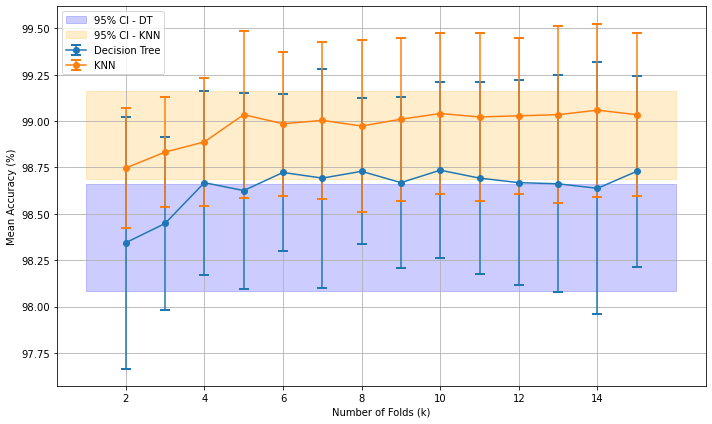

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.utils import resample


X_dt.replace('?', np.nan, inplace=True)

# Placeholder for storing bootstrap accuracy estimates
bootstrap_accuracies_dt = []
bootstrap_accuracies_knn = []

# Number of bootstrap iterations
n_iterations = 500


for _ in range(n_iterations):
    # DT Classifier
    X_bootstrap_dt, y_bootstrap_dt = resample(X_train_val_dt_smote, y_train_val_dt_smote)
    oob_mask = ~X_train_val_dt_smote.index.isin(X_bootstrap_dt.index)
    X_oob = X_train_val_dt_smote[oob_mask]
    y_oob = y_train_val_dt_smote[oob_mask]
    
    dt_classifier = DecisionTreeClassifier(ccp_alpha= 0.0, max_depth= 40, min_samples_leaf= 1, min_samples_split= 5)
    
    dt_classifier.fit(X_bootstrap_dt, y_bootstrap_dt)
    accuracy_dt = dt_classifier.score(X_oob, y_oob) * 100
    bootstrap_accuracies_dt.append(accuracy_dt)
    
    # KNN Classifier
    X_bootstrap_knn, y_bootstrap_knn = resample(X_train_val_knn_smote, y_train_val_knn_smote)
    oob_mask = ~X_train_val_knn_smote.index.isin(X_bootstrap_knn.index)
    X_oob = X_train_val_knn_smote[oob_mask]
    y_oob = y_train_val_knn_smote[oob_mask]
    
    knn_classifier = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 3, p= 3)
    
    knn_classifier.fit(X_bootstrap_knn, y_bootstrap_knn)
    accuracy_knn = knn_classifier.score(X_oob, y_oob) * 100
    bootstrap_accuracies_knn.append(accuracy_knn)

# Calculate the mean and 95% confidence interval for Decision Tree
bootstrap_mean_dt = np.mean(bootstrap_accuracies_dt)
bootstrap_ci_dt = np.percentile(bootstrap_accuracies_dt, [2.5, 97.5])

# Calculate the mean and 95% confidence interval for KNN
bootstrap_mean_knn = np.mean(bootstrap_accuracies_knn)
bootstrap_ci_knn = np.percentile(bootstrap_accuracies_knn, [2.5, 97.5])

# Define the range of k values
k_values = range(2, 16) 

mean_accuracies = {'Decision Tree': [], 'KNN': []}
std_accuracies = {'Decision Tree': [], 'KNN': []}

# Define the classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(ccp_alpha= 0.0, max_depth= 40, min_samples_leaf= 1, min_samples_split= 5),
    'KNN': KNeighborsClassifier(metric= 'manhattan', n_neighbors= 3, p= 3)
}

X_data = {
    'Decision Tree': X_train_res_dt,
    'KNN': X_train_res_knn
}

y_data = {
    'Decision Tree': y_train_res_dt,
    'KNN': y_train_res_knn
}

# Loop over different k values
for k in k_values:
    for clf_name, clf in classifiers.items():
        # Perform cross-validation and get accuracy scores
        accuracies = cross_val_score(clf, X_data[clf_name], y_data[clf_name], cv=k, scoring='accuracy')
        
        # Convert accuracies to percentage and store the results
        accuracies = accuracies * 100
        mean_accuracies[clf_name].append(np.mean(accuracies))
        std_accuracies[clf_name].append(np.std(accuracies))
        
        
print(mean_accuracies['Decision Tree'])
print(mean_accuracies['KNN'])
print(std_accuracies['Decision Tree'])
print(std_accuracies['KNN'])

# Plot the mean accuracy with error bars (standard deviation) for both classifiers
plt.figure(figsize=(10, 6))
for clf_name in classifiers.keys():
    plt.errorbar(k_values, mean_accuracies[clf_name], yerr=std_accuracies[clf_name], 
                 fmt='-o', capsize=5, capthick=2, label=f'{clf_name}')

lower_bound_dt = bootstrap_ci_dt[0]  # 2.5th percentile
upper_bound_dt = bootstrap_ci_dt[1]  # 97.5th percentile

plt.fill_between([min(k_values) - 1, max(k_values) + 1], 
                 [lower_bound_dt] * 2, 
                 [upper_bound_dt] * 2, 
                 color='blue', alpha=0.2, label='95% CI - DT')

lower_bound_knn = bootstrap_ci_knn[0]  # 2.5th percentile
upper_bound_knn = bootstrap_ci_knn[1]  # 97.5th percentile

plt.fill_between([min(k_values) - 1, max(k_values) + 1], 
                 [lower_bound_knn] * 2, 
                 [upper_bound_knn] * 2, 
                 color='orange', alpha=0.2, label='95% CI - KNN')

# Set the labels and title
plt.xlabel('Number of Folds (k)')
plt.ylabel('Mean Accuracy (%)')
plt.legend()

# Set grid lines every 2 steps on the x-axis
plt.xticks(np.arange(min(k_values), max(k_values) + 1, 2))
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig('generalization_check.png')
plt.show()


In [41]:
lower_bound_knn

98.6882103586765

In [42]:
KNN = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 3, p= 3, weights= 'distance')
print(cross_val_score(KNN, X_train_res_knn, y_train_res_knn, cv = 5, scoring = 'accuracy'))

[0.98808433 0.98808433 0.99572258 0.99572258 0.99724939]


In [44]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.25)
X_train_res_knn, y_train_res_knn = smote_tomek.fit_resample(X_train_knn, y_train_knn)

X_train_res_knn = scaler.fit_transform(X_train_res_knn)
X_test_knn = scaler.transform(X_test_knn)
    
y_train_res_knn = label_encoder.fit_transform(y_train_res_knn)
y_test_knn = label_encoder.transform(y_test_knn)

KNN.fit(X_train_res_knn, y_train_res_knn)

y_pred = KNN.predict(X_test_knn)
print(accuracy_score(y_pred, y_test_knn))

0.979994115916446


If the mean value is lower than the true accuracies or the gray line, then it is biased. Since the performance of the model was influence by the data it received. Can be septic to values such as k = 2 and k = 5.

## 5x2 t test from MLxtend

In [59]:
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.over_sampling import SMOTE
from sklearn.utils.validation import check_is_fitted

class SMOTEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, smote_params=None):
        self.base_estimator = base_estimator
        self.smote_params = smote_params if smote_params is not None else {}

    def fit(self, X, y):
        smote = SMOTE(**self.smote_params)
        X_res, y_res = smote.fit_resample(X, y)
        self.base_estimator.fit(X_res, y_res)
        # Set the classes_ attribute
        self.classes_ = self.base_estimator.classes_
        return self

    def predict(self, X):
        check_is_fitted(self)
        return self.base_estimator.predict(X)

    def predict_proba(self, X):
        check_is_fitted(self)
        return self.base_estimator.predict_proba(X)

    def decision_function(self, X):
        check_is_fitted(self)
        return self.base_estimator.decision_function(X)


clf1 = SMOTEClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha= 0.0, max_depth= 40, min_samples_leaf= 1, min_samples_split= 5))
clf2 = SMOTEClassifier(base_estimator=KNeighborsClassifier(metric= 'manhattan', n_neighbors= 3, p= 3))


t, p = paired_ttest_5x2cv(estimator1=clf1,
                          estimator2=clf2,
                          X=X_train_res_knn,
                          y=y_train_res_knn,
                          random_seed=1)

print(f't-statistic: {t}')
print(f'p-value: {p}')


t-statistic: -1.627558269670566
p-value: 0.164547247071573


# Testing final models on the test data

In [60]:
DT = DecisionTreeClassifier(ccp_alpha= 0.0, max_depth= 40, min_samples_leaf= 1, min_samples_split= 5)
KNN = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 3, p= 3)

DT.fit(X_train_res_dt, y_train_res_dt)
y_pred = DT.predict(X_test_dt)
print(accuracy_score(y_pred, y_test_dt))

KNN.fit(X_train_res_knn, y_train_res_knn)
y_pred = KNN.predict(X_test_knn)
print(accuracy_score(y_pred, y_test_knn))

0.9838155958803335
0.9789112309955861


# Additional graphs used for explanation

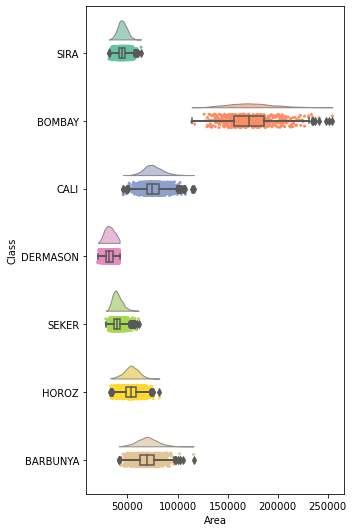

In [66]:
f, ax = plt.subplots(figsize=(5, 7.5))

pt.RainCloud(x='Class', y='Area', data=df_dt, palette="Set2", 
             bw=.2, width_viol=.6, ax=ax, orient="h", alpha=.65, dodge=True)
plt.tight_layout()
plt.savefig('area_distribution.png')
plt.show()

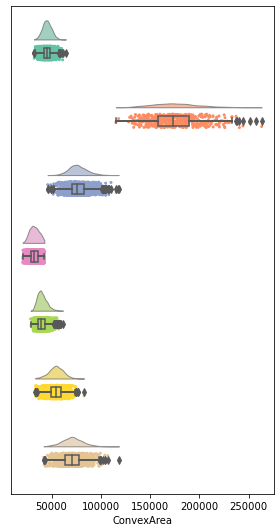

In [67]:
f, ax = plt.subplots(figsize=(4, 7.5))

pt.RainCloud(x='Class', y='ConvexArea', data=df_dt, palette="Set2", 
             bw=.2, width_viol=.6, ax=ax, orient="h", alpha=.65, dodge=True)

ax.set_ylabel('') 
ax.set_yticks([])
ax.set_yticklabels([]) 
plt.tight_layout()

plt.savefig('convexarea_distribution.png')
plt.show()

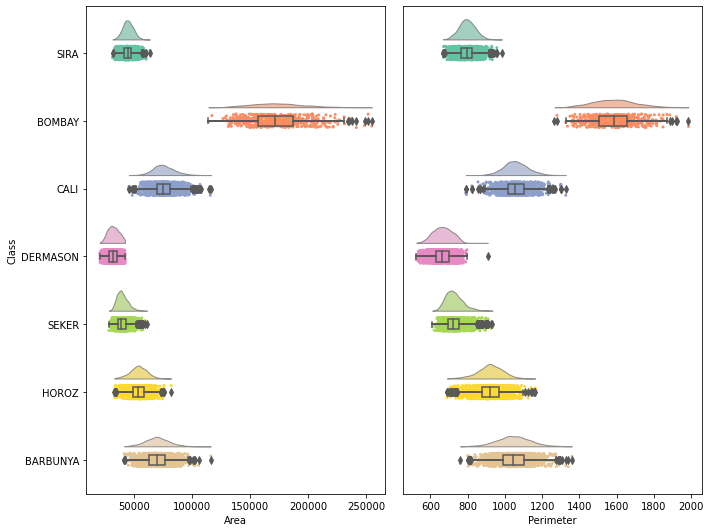

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7.5)) 

pt.RainCloud(x='Class', y='Area', data=df_dt, palette="Set2", 
             bw=.2, width_viol=.6, ax=ax1, orient="h", alpha=.65, dodge=True)


pt.RainCloud(x='Class', y='Perimeter', data=df_dt, palette="Set2", 
             bw=.2, width_viol=.6, ax=ax2, orient="h", alpha=.65, dodge=True)
ax2.set_ylabel('') 
ax2.set_yticks([])
ax2.set_yticklabels([]) 

plt.tight_layout()
plt.savefig('combined_distribution.png')

plt.show()


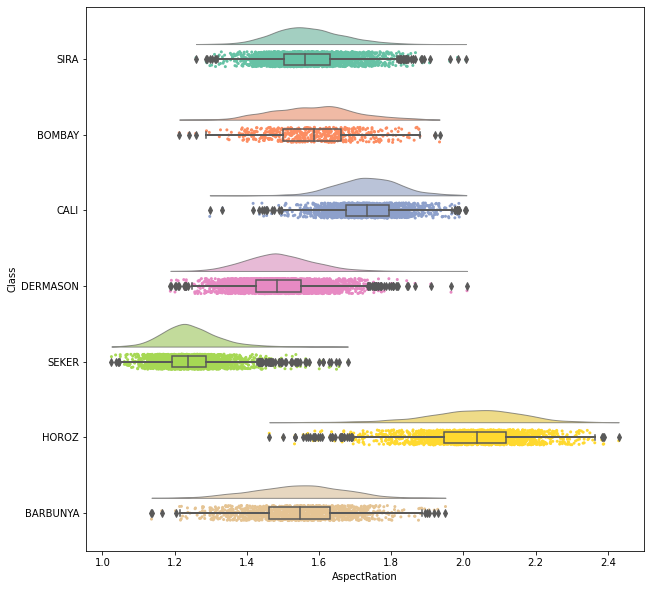

In [72]:
f, ax = plt.subplots(figsize=(10, 10))

pt.RainCloud(x='Class', y='AspectRation', data=df_knn, palette="Set2", 
             bw=.2, width_viol=.6, ax=ax, orient="h", alpha=.65, dodge=True)

plt.show()